<a href="https://colab.research.google.com/github/AgatheMommeja/ClimateCommunity-project/blob/main/Explore_Optimization_Output_MO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial exploration of results

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pygmo as pg
import random
import rasterio
import shapely
import matplotlib.pyplot as plt

In [ ]:
from rasterstats import zonal_stats
from rasterio import features
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import float64
from scipy.signal import convolve2d

Set the random seed.

In [ ]:
random.seed(1234)

Set names to filepaths.

In [ ]:
# specify file path to the temperature data
temperature_raster_path = 'input_data/LST_thehague_average_raster.tif'

# specify file path to the rooftop data
buildings_shapefile_path = 'input_data/Platte_daken_classificatie.shp'

# specify file path to the administrative boundary data
admin_boundaries_shapefile_path = 'input_data/DenHaagPC5.shp'

# specify file path to the indicator data
cbs_data_PC5_path = 'input_data/pc5_2020_vol.xlsx'

# specify file path to optimization ouput
optimization_output_path = 'output_data/optimization_output_mo_50_socsec.json'

# specify file path to fitness evolution
fitness_evolution_path = 'output_data/evolution_fitness_values_mo_50_socsec.csv'

Read in input data.

In [ ]:
# read in administrative boundary data
admin_units = gpd.read_file(admin_boundaries_shapefile_path)

# read in rooftop data
building_rooftops_unfiltered = gpd.read_file(buildings_shapefile_path)

# read in social indicator data
cbs_data_PC5 = pd.read_excel(cbs_data_PC5_path)

# read in .csv file with fitness evolution data
fitness_evolution = pd.read_csv(fitness_evolution_path)

Read in optimization output data.

In [ ]:
import json
with open(optimization_output_path, 'r') as f:
    optimization_output = json.load(f)

Store the optimization output data in a dataframe.

In [ ]:
# Step 2: Create an empty list to store dataframes
dfs = []

# Step 3: Iterate over the JSON data and create dataframes
for index, values in optimization_output.items():
    temperature = values['Temperature Reduction']
    coverage = values['Vulnerable Coverage']
    distribution = values['Configuration']
    df = pd.DataFrame({'temperature_reduction': [temperature],'coverage': [coverage], 'green_roof': [distribution]})
    dfs.append(df)

# Step 4: Concatenate the list of dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#### Extend building data

Calculate area for all rooftops.

In [ ]:
# Calculate total rooftop area and green rooftop area for each building
building_rooftops_unfiltered['rooftop_area'] = building_rooftops_unfiltered.area

Define function to filter dataframe.

In [ ]:
def filter_dataframe(df, cols_to_select, flatness_score, threshold):

    # Select rows where column A is higher than the threshold
    mask = df[flatness_score] > threshold
    df_filtered = df.loc[mask]

    # Select only the specified columns from filtered dataframe
    df_selected = df_filtered.loc[:, cols_to_select]

    # return the dataframe that contains only the buildings that are flat enough for green roofs and keep only relevant columns
    return df_selected

Specify input parameters to clean building rooftop dataframe.

In [ ]:
# Specify input parameters for the filter dataframe function
building_rooftop_columns = ['identifica','platdak_in','rooftop_area','geometry']
gr_flatness_score_column = 'platdak_in'
gr_threshold = 60

Create filtered dataframe running the filter dataframe function.

In [ ]:
building_rooftops = filter_dataframe(building_rooftops_unfiltered,
                                     building_rooftop_columns,
                                     gr_flatness_score_column,
                                     gr_threshold)

Add configuration array to building dataframe.

In [ ]:
# Get the first array from the last column
first_array = df.loc[0, 'green_roof']

# Create a new column in the building geometry dataframe
building_rooftops['green_roof'] = first_array

Export geodataframe with building geometries and optimized green roof distribution to a shapefile.

In [ ]:
building_rooftops_path = 'output_data/building_geometries.shp'

In [ ]:
# building_rooftops.to_file(building_rooftops_path)

In [ ]:
# Calculate total rooftop area and green rooftop area for each building
admin_units['admin_units_area'] = admin_units.area

### Explore results

Select only rooftops with a greenroof.

In [ ]:
greenroof_rooftops = building_rooftops[building_rooftops['green_roof'] == 1].copy()

In [ ]:
greenroof_rooftops = greenroof_rooftops.rename(columns={'rooftop_area': 'green_rooftop_area'})

Perform spatial join to count the number of green roofs per PC5 zone.

In [ ]:
greenroof_spatial_join = gpd.sjoin(greenroof_rooftops, admin_units, how='inner', predicate='within')

Count the number of buildings per PC5 zone.

In [ ]:
# Group by postal code zone and calculate rooftop area sum
rooftop_area_per_zone = greenroof_spatial_join.groupby('PC5')['green_rooftop_area'].sum()

Merge the dataframe so the map can be plotted.

In [ ]:
merged_gdf = admin_units.merge(rooftop_area_per_zone, on='PC5', how='left')

In [ ]:
merged_gdf['greenroof_area_m2'] = merged_gdf['green_rooftop_area']/merged_gdf['admin_units_area']

Plot the green roof area per square meter of spatial unit.

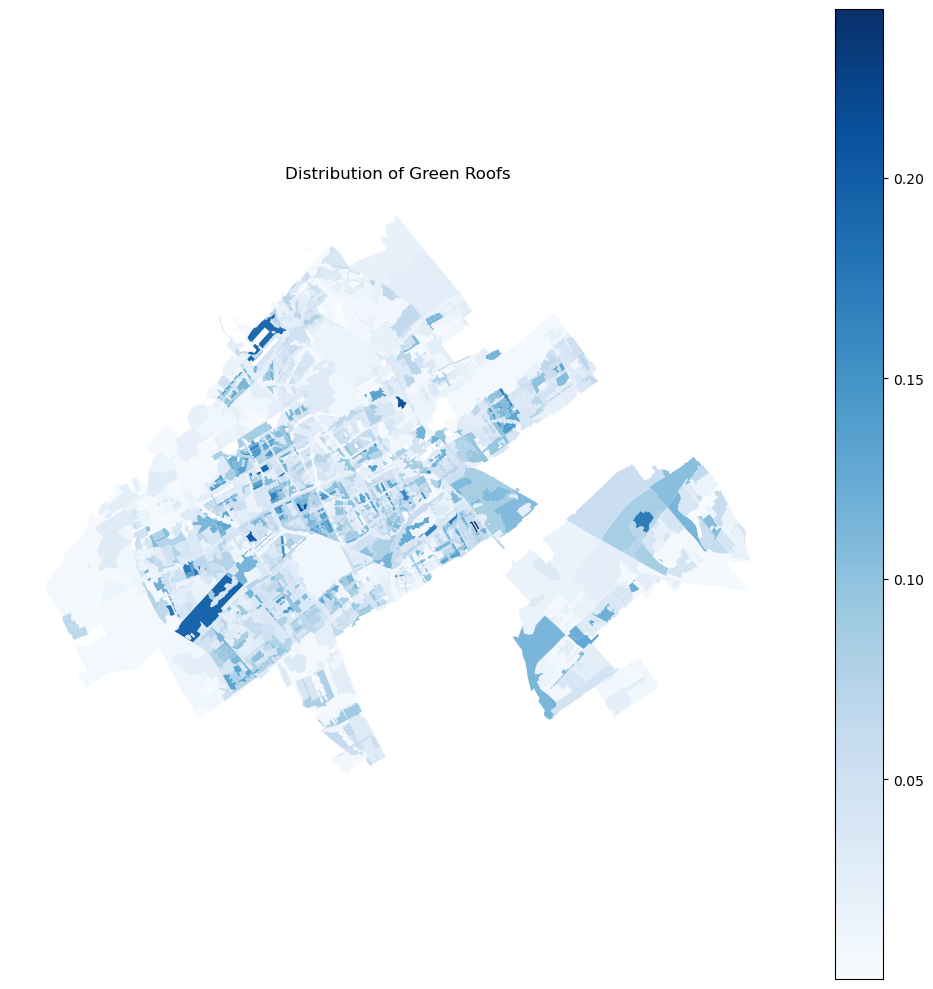

In [ ]:
import matplotlib.pyplot as plt

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='greenroof_area_m2', cmap='Blues', linewidth=0.1, ax=ax, legend=True)

# Set the title and axis labels
ax.set_title('Distribution of Green Roofs')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_axis_off()
fig.tight_layout()

# Show the plot
plt.show()


### Exploring Fitness Evolution

Plot the evolution of the fitness value during the optimization process.

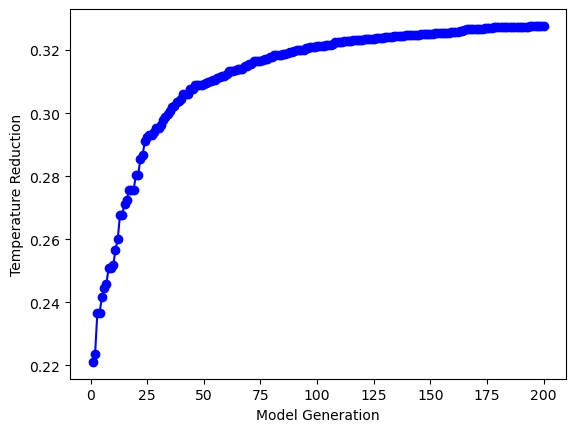

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named "df" with columns "Verboisty" and "Temperature reduction"

# Extract the data from the DataFrame
x = fitness_evolution["Verbosity"]
y = -fitness_evolution["Temperature reduction"]

# Create the plot
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Set labels for the axes
plt.xlabel("Model Generation")
plt.ylabel("Temperature Reduction")

# Show the plot
plt.show()

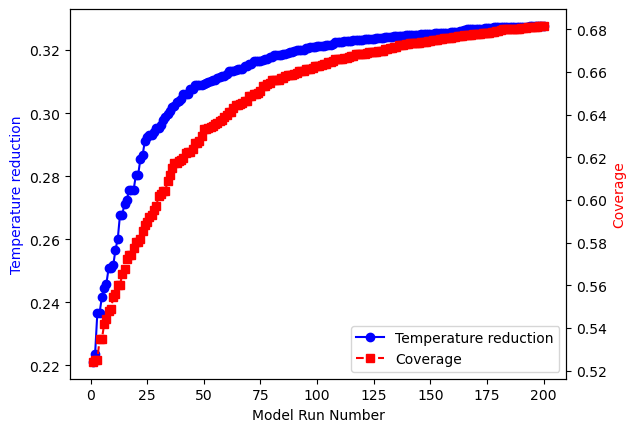

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named "df" with columns "Verboisty", "Temperature reduction", and "Coverage"

# Extract the data from the DataFrame
x = fitness_evolution["Verbosity"]
y_temp_reduction = -fitness_evolution["Temperature reduction"]
y_coverage = -fitness_evolution["Vulnerability points covered"]

# Create the plot
fig, ax1 = plt.subplots()

# Plot the first column on the left y-axis
ax1.plot(x, y_temp_reduction, marker='o', linestyle='-', color='blue', label='Temperature reduction')
ax1.set_xlabel("Model Run Number")
ax1.set_ylabel("Temperature reduction", color='blue')

# Create a twin y-axis on the right side
ax2 = ax1.twinx()

# Plot the second column on the right y-axis
ax2.plot(x, y_coverage, marker='s', linestyle='--', color='red', label='Coverage')
ax2.set_ylabel("Coverage", color='red')

# Set a legend for the lines
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.show()